#### Learning objectives

By the end of this lab, you will:

 - Import necessary libraries and load the dataset.
 - Load a pre-trained model, VGG16, excluding the top layers.
 - Add new layers on top of the base model and compile the model.
 - Train the model on the new dataset.
 - Unfreeze some of the layers of the pre-trained model and fine-tune them.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os

**Load pre-trained model**

In [2]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

2025-06-25 20:44:29.926458: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-06-25 20:44:29.926481: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-25 20:44:29.926488: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-25 20:44:29.926516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-25 20:44:29.926530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


**Create and compile the model**

In [3]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [4]:
# Create directories
os.makedirs('sample_data/class_a', exist_ok=True)
os.makedirs('sample_data/class_b', exist_ok=True)

# Create image set
for i in range(20):
    # Create blank white images
    img = Image.fromarray(np.ones((224, 224, 3), dtype=np.uint8)*225)
    img.save(f'sample_data/class_a/img_{i}.jpg')

    # Create blank black images
    img = Image.fromarray(np.ones((224, 224, 3), dtype=np.uint8))
    img.save(f'sample_data/class_b/img_{i}.jpg')
print('Images are successfully saved in sample_data')

Images are successfully saved in sample_data


**Training model generation**

In [5]:
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory('sample_data',
                                                    target_size=(224, 224),
                                                    class_mode='binary',
                                                    batch_size=32,
                                                    seed=42,
                                                    shuffle=True)
print(f'Training images: {train_generator.samples} of {train_generator.num_classes} classes.')
if train_generator.samples>0:
    model.fit(train_generator, epochs=10, batch_size=32)

Found 40 images belonging to 2 classes.
Training images: 40 of 2 classes.
Epoch 1/10


2025-06-25 20:44:30.667235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 558ms/step - loss: 2.4564 - accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 0s 96ms/step - loss: 10.0638 - accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 0s 96ms/step - loss: 7.7570 - accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 0s 351ms/step - loss: 4.6348 - accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 0s 349ms/step - loss: 1.8786 - accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 0s 349ms/step - loss: 0.1736 - accuracy: 0.9000
Epoch 7/10
2/2 [==============================] - 0s 95ms/step - loss: 0.0727 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 96ms/step - loss: 0.9128 - accuracy: 0.5000
Epoch 9/10
2/2 [==============================] - 0s 349ms/step - loss: 1.8986 - accuracy: 0.5000
Epoch 10/10
2/2 [==============================] - 0s 350ms/step - loss: 1.7612 - accuracy: 0.5000


**Fine tune the model by un-freezing some of the layers from base_model**

In [6]:
for layer in base_model.layers[-4:]:
    layer.trainable=True

# Recompile the model and train
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_generator, epochs=10)

Epoch 1/10
2/2 [==============================] - 2s 606ms/step - loss: 0.7615 - accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 1s 425ms/step - loss: 0.7732 - accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 1s 425ms/step - loss: 0.6978 - accuracy: 0.4000
Epoch 4/10
2/2 [==============================] - 1s 118ms/step - loss: 0.6848 - accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 1s 424ms/step - loss: 0.8145 - accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 1s 423ms/step - loss: 0.6947 - accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 1s 424ms/step - loss: 0.6302 - accuracy: 0.5000
Epoch 8/10
2/2 [==============================] - 1s 423ms/step - loss: 0.6882 - accuracy: 0.5000
Epoch 9/10
2/2 [==============================] - 1s 423ms/step - loss: 0.6779 - accuracy: 0.5000
Epoch 10/10
2/2 [==============================] - 1s 118ms/step - loss: 0.6451 - accuracy: 0.5000


**Visualize the data**

Lets first generate training and validation dataset

In [7]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_generator_ = datagen.flow_from_directory('sample_data',
                                               batch_size=32,
                                               target_size=(224, 224),
                                               shuffle=True,
                                               class_mode='binary',
                                               subset='training')

validation_generator = datagen.flow_from_directory('sample_data',
                                                   batch_size=32,
                                                   target_size=(224, 224),
                                                   shuffle=True,
                                                   class_mode='binary',
                                                   subset='validation')
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
history = model.fit(train_generator, epochs=10, batch_size=32, validation_data=validation_generator)

loss={'Training_Loss': model.history.history['loss'],
      'Val_Loss': model.history.history['val_accuracy']
}

Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/10
2/2 [==============================] - 1s 679ms/step - loss: 1.1927 - accuracy: 0.5000 - val_loss: 0.5027 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 1s 532ms/step - loss: 0.5421 - accuracy: 0.5000 - val_loss: 0.6581 - val_accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 1s 533ms/step - loss: 0.6754 - accuracy: 1.0000 - val_loss: 0.6803 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 1s 533ms/step - loss: 0.6740 - accuracy: 1.0000 - val_loss: 0.6404 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 532ms/step - loss: 0.5840 - accuracy: 1.0000 - val_loss: 0.4923 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 1s 532ms/step - loss: 0.5086 - accuracy: 1.0000 - val_loss: 0.4654 - val_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 1s 533ms/step - loss: 0.4119 - 

**Plotting data**

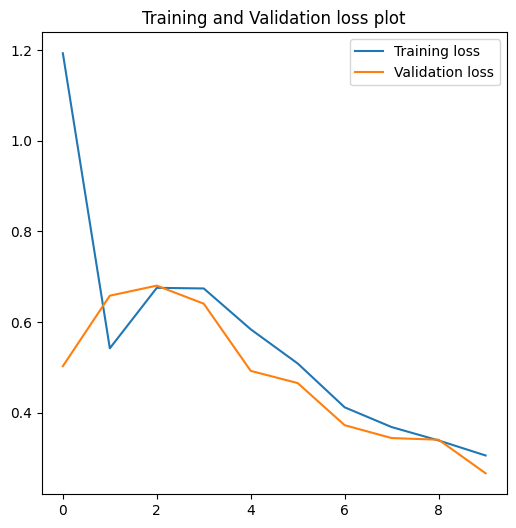

In [8]:
plt.figure(figsize=(6, 6))
plt.plot(model.history.history['loss'], label='Training loss')
plt.plot(model.history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss plot')
plt.legend()
plt.show()

**Changing the optimizer to `sgd`**

Epoch 1/10
2/2 [==============================] - 1s 675ms/step - loss: 0.2279 - accuracy: 1.0000 - val_loss: 0.0889 - val_accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 1s 218ms/step - loss: 0.0775 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 1s 218ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 1s 217ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 217ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 1s 217ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 1s 527ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 8/10
2/2 [====

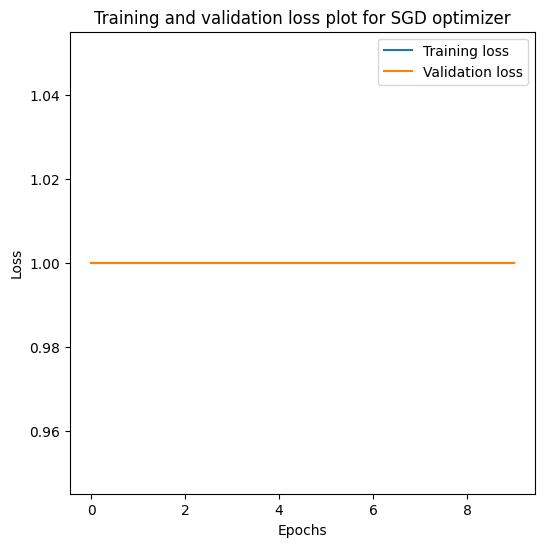

In [9]:
from tensorflow.keras.models import clone_model
def reset_model(model):
    model_clone = clone_model(model)
    model_clone.set_weights(model.get_weights())
    return model_clone

# Prepare to reset the model for each optimizer test
initial_model = reset_model(model)

# Experiment with SGD optimizer
sgd_model = reset_model(initial_model)

sgd_model.compile(optimizer='sgd', metrics=['accuracy'], loss='binary_crossentropy')
history = sgd_model.fit(train_generator, epochs=10, validation_data=validation_generator)

plt.figure(figsize=(6, 6))
plt.plot(sgd_model.history.history['accuracy'], label='Training loss')
plt.plot(sgd_model.history.history['val_accuracy'], label='Validation loss')
plt.title('Training and validation loss plot for SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Change compiler to RMSprop optimizer**

Epoch 1/10
2/2 [==============================] - 2s 706ms/step - loss: 1.5519 - accuracy: 0.5500 - val_loss: 61.8181 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 1s 247ms/step - loss: 46.7377 - accuracy: 0.5500 - val_loss: 3.1442e-04 - val_accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 1s 229ms/step - loss: 3.6734e-04 - accuracy: 1.0000 - val_loss: 7.7486e-07 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 1s 538ms/step - loss: 5.2154e-07 - accuracy: 1.0000 - val_loss: 3.5763e-07 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 539ms/step - loss: 3.0994e-07 - accuracy: 1.0000 - val_loss: 2.3842e-07 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 1s 229ms/step - loss: 2.3842e-07 - accuracy: 1.0000 - val_loss: 1.7881e-07 - val_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 1s 229ms/step - loss: 1.7881e-07 - accuracy: 1.0000 - val_loss: 1.1921e-

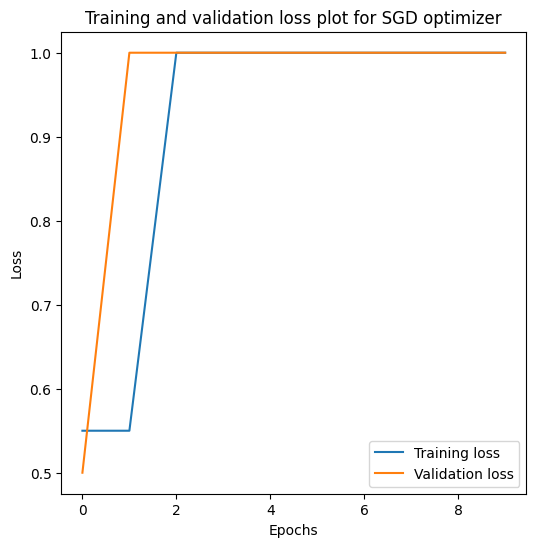

In [10]:
rms_model = reset_model(initial_model)

rms_model.compile(optimizer='rmsprop', metrics=['accuracy'], loss='binary_crossentropy')
history = rms_model.fit(train_generator, epochs=10, validation_data=validation_generator)

plt.figure(figsize=(6, 6))
plt.plot(rms_model.history.history['accuracy'], label='Training loss')
plt.plot(rms_model.history.history['val_accuracy'], label='Validation loss')
plt.title('Training and validation loss plot for SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Load and preprocess the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'sample_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Evaluate the fine-tuned model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Found 40 images belonging to 2 classes.
2/2 [==============================] - 0s 92ms/step - loss: 0.2665 - accuracy: 1.0000
Test Accuracy: 100.00%
Test Loss: 0.2665
